# Dataset loading


In [1]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# load the MNIST dataset.
mnist = fetch_openml('mnist_784', version=1)

<Axes: xlabel='class', ylabel='count'>

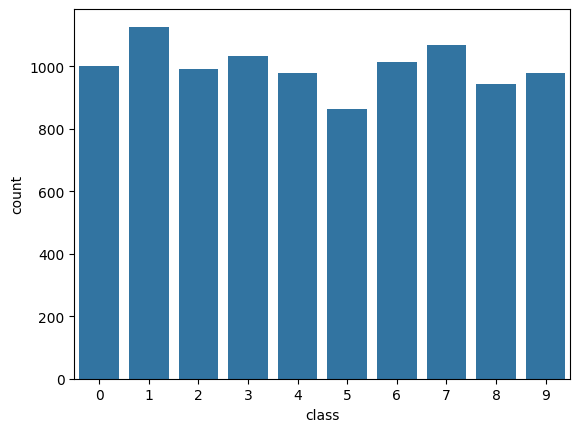

In [3]:
N_SAMPLES = 10_000
x, y = mnist['data'][:N_SAMPLES], mnist['target'][:N_SAMPLES]
Y = y.to_numpy().astype(np.uint8)
m_rows, n_cols = x.shape

# Plot the count of each label
sns.countplot(y.to_frame(), x='class')

In [4]:
# Create the features matrix X and add the bias element to each row
mat_X = np.c_[np.ones(x.shape[0]), x.to_numpy()]
mat_X

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [5]:
# Hot encode y.
Y_hot = np.zeros(shape=(m_rows, 10), dtype=np.uint8)
# Go over each row and place 1 at the index of the label, i.e label 3 will be placed at the 3rd index.
Y_hot[range(m_rows), Y] = 1
Y_hot

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 1, 0, 0]], dtype=uint8)

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(mat_X, Y_hot, test_size=0.2, random_state=42)
f"X_train{X_train.shape}, X_test{X_test.shape}, Y_train{Y_train.shape}, Y_test{Y_test.shape}"

'X_train(8000, 785), X_test(2000, 785), Y_train(8000, 10), Y_test(2000, 10)'

In [7]:
y_lables = np.argmax(Y_train, axis=1)
y_lables

array([6, 2, 5, ..., 9, 0, 5])

# Part A - The perceptron learning algorithm

In [8]:
class PLA:
  def __init__(self, max_epochs = 1000):
    self.max_epochs = max_epochs

  def fit(self, X, Y):
    m, n_features = X.shape

    self.w_with_bias = np.zeros(n_features)
    self.pocket = self.w_with_bias
    min_err = float('inf')

    for _ in tqdm(range(self.max_epochs)):
      errors = 0
      for i in range(m):
        y_hat = self.predict_one(X[i])

        if y_hat != Y[i]:
          self.w_with_bias += Y[i] * X[i]
          errors += 1

      if errors < min_err:
          min_err = errors
          self.pocket = self.w_with_bias

      if errors == 0:
        break

  def predict_one(self, x):
    return np.sign(self.w_with_bias.T @ x)

  def predict(self, X):
    return np.apply_along_axis(self.predict_one, 1, X)

  def get_wb(self):
    return self.pocket

In [9]:
class PLAOneVsAll:
  def __init__(self, max_epochs = 1000):
    self.max_epochs = max_epochs

  def fit(self, X, Y):
    m, n_features = X.shape
    n_classes = Y.shape[1]
    self.w_mat = np.zeros(shape=(n_classes, n_features))

    y_signed = np.where(Y == 0, -1, 1)
    for i in tqdm(range(n_classes)):
      classifier = PLA(self.max_epochs)
      classifier.fit(X, y_signed[:, i])
      self.w_mat[i] = classifier.get_wb()

  def predict(self, X):
    """Gets the class with the highest confidence score"""
    return (self.w_mat @ X.T).argmax(axis=0)

In [10]:
one_vs_all = PLAOneVsAll()
one_vs_all.fit(X_train, Y_train)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [11]:
def create_confusion_matrix(y_true, y_pred, dim=10):
  m = len(y_true)

  confusion_matrix = np.zeros((dim, dim), dtype=np.uint32)
  for i in range(m):
    confusion_matrix[y_true[i], y_pred[i]] += 1

  return confusion_matrix

In [12]:
def plot_confusion_matrix(actual, predicted, dim=10, *, title=None, class_names=None):
    cm = create_confusion_matrix(actual, predicted, dim)

    sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

In [13]:
def calculate_accuracy(y_true, y_pred, dim=10):
    cm = create_confusion_matrix(y_true, y_pred, dim)
    return np.trace(cm) / cm.sum()


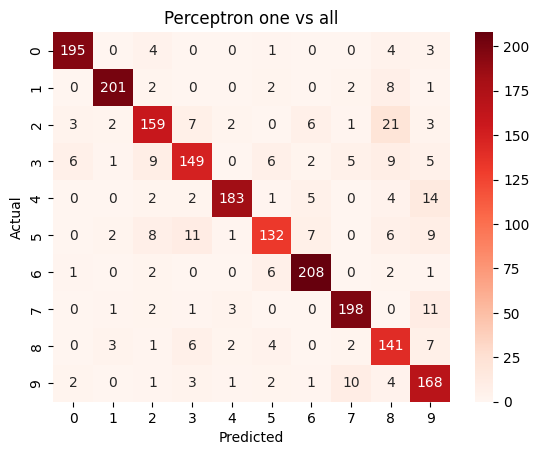


Accuracy: 86.7%


In [14]:
y_true = Y_test.argmax(axis=1)
y_pred = one_vs_all.predict(X_test)

plot_confusion_matrix(y_true, y_pred, title="Perceptron one vs all", class_names=range(10))
print(f"\nAccuracy: {calculate_accuracy(y_true, y_pred) * 100}%")

In [88]:
def generate_confusion_table(cm, cls):
  ct = np.zeros((2,2))

  TP = cm[cls, cls]
  FP = cm[:, cls].sum() - TP
  FN = cm[cls, :].sum() - TP
  TN = cm.sum() - TP - FP - FN

  ct[0,0] = TP
  ct[0,1] = FN
  ct[1,0] = FP
  ct[1,1] = TN

  return ct

cm = create_confusion_matrix(y_true, y_pred)
ct_of_classes = [generate_confusion_table(cm, i) for i in range(10)]
df = pd.DataFrame(range(10), columns=["Digits"])
df["TPR"] = np.nan

for cls in range(10):
  ct = ct_of_classes[cls]
  TP = ct[0, 0]
  FN = ct[0, 1]
  df.loc[cls, "TPR"] = TP / (TP + FN)

df

,Digits,TPR
0,0,0.942029
1,1,0.930556
2,2,0.779412
3,3,0.776042
4,4,0.867299
5,5,0.750000
6,6,0.945455
7,7,0.916667
8,8,0.849398
9,9,0.875000


# Part B - Softmax Regression

In [92]:
class SoftmaxRegression:
  _WIN_SIZE = 10

  def __init__(self, max_epochs = 1000):
    self._max_epochs = max_epochs
    self._window = np.zeros(shape(SoftmaxRegression._WIN_SIZE))

  def fit(self, X, Y):
    m, n_features = X.shape
    n_classes = Y.shape[1]

    self._w = np.zeros(shape=(n_classes, n_features))
    self._b = 0

    for _ in range(self._max_epochs):
      for i in range(m):
        pass

  def _dw(self, X, Y, YH):
    """ Derivative of the weights"""
    pass

  def _db():
    """Derivative of the bias"""
    pass

  def _softmax(self, z):
    """Softmax function"""
    exp_z = np.exp(z)
    return exp_z / exp_z.sum()

  def _sigmoid(self, x):
    """Sigmoid function"""
    return 1 / (1 + np.exp(-X))

  def _dsigmoid(self, x):
    """Derivative of the sigmoid function"""
    return self._sigmoid(x) * (1 - self._sigmoid(x))

  def _moving_avg(self):
    """Moving average for the η value"""
    return self._window.sum() / SoftmaxRegression._WIN_SIZE

  def _predict_one(self, X):
    return self._sigmoid(self._w.T @ X + self._b)

  def _error_in_sample(self, y, yh):
    """Evaluate the in-sample error"""

    m = y.shape[0]
    return (1/m) * -np.sum(y * np.log(yh) - (1 - y)*np.log(1 - y))

  def predict(self, X):
    return np.apply_along_axis(self._predict_one, 1, X)



# Part C - Linear Regression